# Import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

import plotly.express as px

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from utils import eda_train_path, validation_df

# Load datasets

In [2]:
train_df = pd.read_csv(eda_train_path)

# Ensure `pickup_date` has datetime type

In [3]:
train_df["pickup_date"] = pd.to_datetime(train_df["pickup_date"])
validation_df["pickup_date"] = pd.to_datetime(validation_df["pickup_date"])
# test_df["pickup_date"] = pd.to_datetime(test_df["pickup_date"])

# Create additional columns

In [4]:
train_df["year_month"] = train_df["pickup_date"].dt.to_period("M")
train_df["month"] = train_df["pickup_date"].dt.month
train_df["day_of_week"] = train_df["pickup_date"].dt.dayofweek
train_df["hour"] = train_df["pickup_date"].dt.hour
train_df["time_of_day"] = pd.cut(
    train_df["pickup_date"].dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=["night", "morning", "day", "evening"],
    right=False,
)

# Notes

- Диапазон данных: с 2019-11-10 по 2022-09-05.
- Данные отсортированы по pickup_date.
- Валидация идет после train (по дате).
- Дубликаты дат (pickup_date) не проблема, так как записи содержат разные параметры (rate, valid_miles, weight).


Вопросы, которые нужно решить:
- Есть ли тренды в rate (растёт/падает со временем)?
- Есть ли сезонность (rate зависит от месяца, дня недели, времени суток)?
- Есть ли автокорреляция (rate зависит от предыдущих значений)?

# Average rate per month

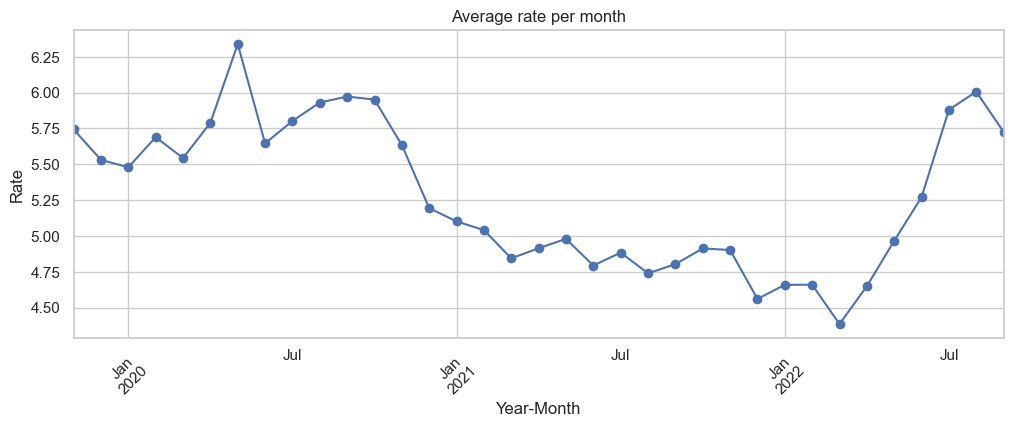

In [5]:
plt.figure(figsize=(12, 4))
train_df.groupby("year_month")["rate"].mean().plot(kind="line", marker="o")
plt.title("Average rate per month")
plt.xlabel("Year-Month")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.show()

Колебания rate с течением времени:
- Начало 2020 года → rate был около 5.5-5.7.
- Лето 2020 → rate резко вырос до 6.3 (максимум).
- 2021 год → постепенное снижение, rate упал ниже 5.0.
- Лето 2022 → новый рост, rate снова выше 6.0.

Похоже на циклический паттерн: Летом rate выше, зимой ниже.

# Trend analysis of rate

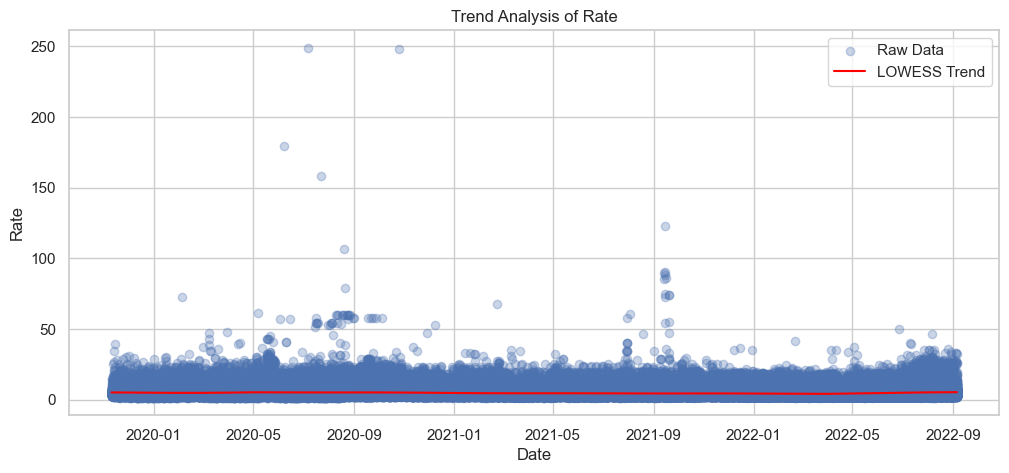

In [6]:
plt.figure(figsize=(12, 5))
plt.scatter(train_df["pickup_date"], train_df["rate"], alpha=0.3, label="Raw Data")
lowess = sm.nonparametric.lowess(train_df["rate"], train_df["pickup_date"], frac=0.1)
plt.plot(train_df["pickup_date"], lowess[:, 1], color="red", label="LOWESS Trend")
plt.title("Trend Analysis of Rate")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.show()

- Тренд очень слабый!
- Красная линия почти плоская → rate не имеет выраженного долгосрочного тренда.
- В отличие от seasonal_decompose, тут видно небольшие колебания, но они слишком слабы для модели.
- Выбросы (rate > 50) заметны, но не влияют на тренд.
-  Долгосрочного тренда практически нет → year_month бесполезен.
-   Но возможны локальные эффекты → rolling_mean_rate_3m всё ещё может помочь.
-   Выбросы (rate > 50) нужно проверить отдельно.

# Box plot for rate by month, day of the week, hour, time of day

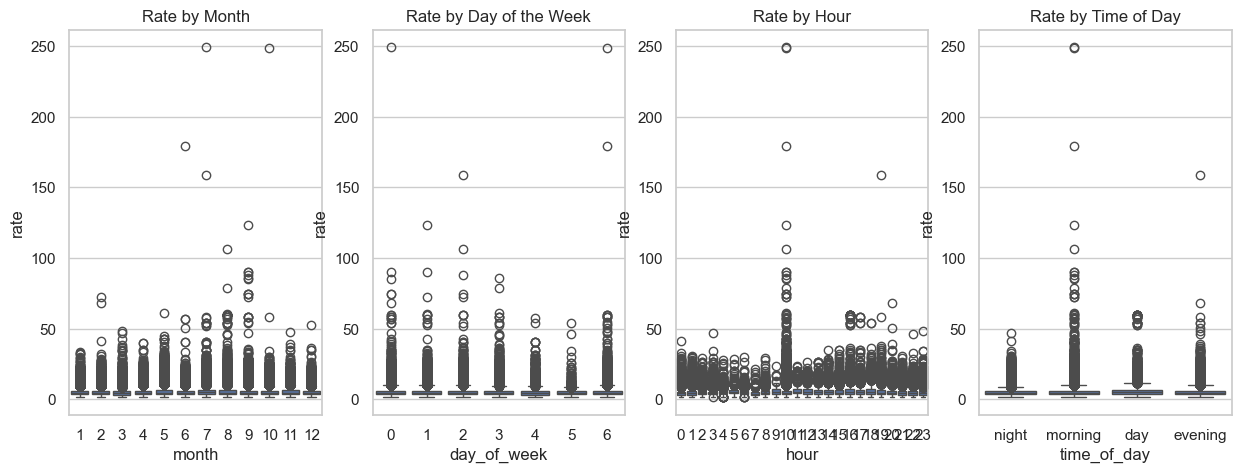

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.boxplot(x="month", y="rate", data=train_df, ax=axes[0])
axes[0].set_title("Rate by Month")

sns.boxplot(x="day_of_week", y="rate", data=train_df, ax=axes[1])
axes[1].set_title("Rate by Day of the Week")

sns.boxplot(x="hour", y="rate", data=train_df, ax=axes[2])
axes[2].set_title("Rate by Hour")

sns.boxplot(x="time_of_day", y="rate", data=train_df, ax=axes[3])
axes[3].set_title("Rate by Time of Day")

plt.show()

- Месяц (month)
    - Практически нет сильных различий между разными месяцами.
    - Есть выбросы, но средний rate остается стабильным.
    - Сезонности нет → Месяц (month) не влияет → НЕ добавляем.
- День недели (day_of_week)
    - Средний rate одинаков во все дни недели.
    - Небольшие колебания, но нет значимой закономерности.
    - День недели не влияет → День недели (day_of_week) не влияет → НЕ добавляем.
- Часы (hour)
    - Видно, что с 10:00 до 14:00 rate немного выше, особенно в 10:00 и 13:00.
    - Это локальный эффект, но его можно учитывать.
    - Час (hour) немного влияет → ДОБАВЛЯЕМ.


# Barplots (average/median rate by month, hour, ...)

In [53]:
def barplot_rate_periodic_groupby(periodic_col_name: str):
    avg_rate = train_df.groupby(periodic_col_name, observed=False)["rate"].mean()
    median_rate = train_df.groupby(periodic_col_name, observed=False)["rate"].median()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))  # Два графика вертикально

    title = periodic_col_name.replace("_", " ").capitalize()

    # График среднего значения
    sns.barplot(x=avg_rate.index, y=avg_rate.values, ax=axes[0])
    axes[0].set_xlabel(title)
    axes[0].set_ylabel("Average Rate")
    axes[0].set_title(f"Average Rate by {title}")

    # График медианы
    sns.barplot(x=median_rate.index, y=median_rate.values, ax=axes[1])
    axes[1].set_xlabel(title)
    axes[1].set_ylabel("Median Rate")
    axes[1].set_title(f"Median Rate by {title}")

    plt.tight_layout()
    plt.show()

    print("Mean rate:")
    print(avg_rate)
    print("\nMedian rate:")
    print(median_rate)

## Year & Month

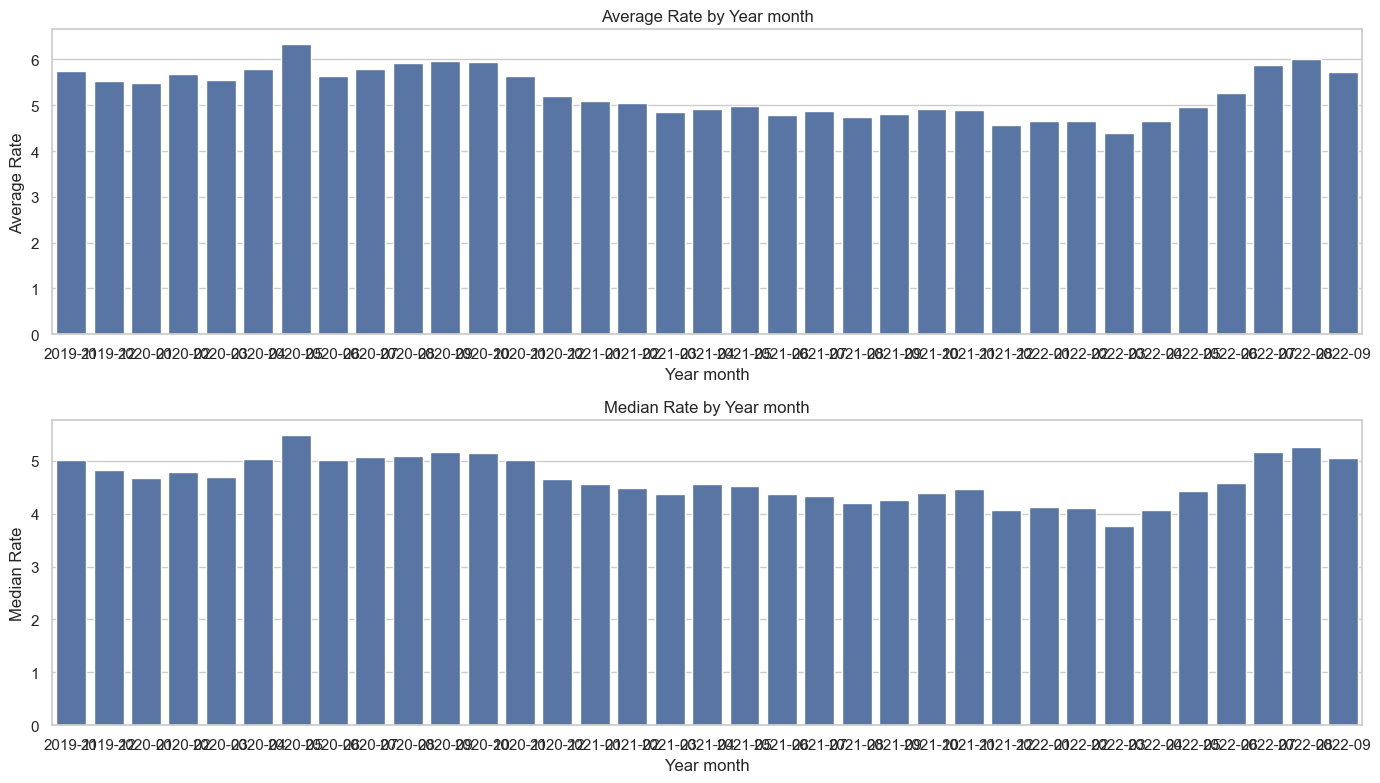

Mean rate:
year_month
2019-11    5.742568
2019-12    5.530710
2020-01    5.478535
2020-02    5.689104
2020-03    5.543166
2020-04    5.789135
2020-05    6.338630
2020-06    5.645438
2020-07    5.801735
2020-08    5.930310
2020-09    5.972449
2020-10    5.950890
2020-11    5.633839
2020-12    5.193547
2021-01    5.101174
2021-02    5.040582
2021-03    4.843604
2021-04    4.914216
2021-05    4.979187
2021-06    4.793440
2021-07    4.883496
2021-08    4.738993
2021-09    4.802964
2021-10    4.912599
2021-11    4.901695
2021-12    4.560368
2022-01    4.658687
2022-02    4.659495
2022-03    4.385284
2022-04    4.649178
2022-05    4.966045
2022-06    5.270337
2022-07    5.880457
2022-08    6.005923
2022-09    5.725208
Freq: M, Name: rate, dtype: float64

Median rate:
year_month
2019-11    5.01160
2019-12    4.83155
2020-01    4.66790
2020-02    4.78120
2020-03    4.69310
2020-04    5.04075
2020-05    5.48800
2020-06    5.01420
2020-07    5.07860
2020-08    5.09500
2020-09    5.15920
2020-10 

In [54]:
barplot_rate_periodic_groupby("year_month")

## Month

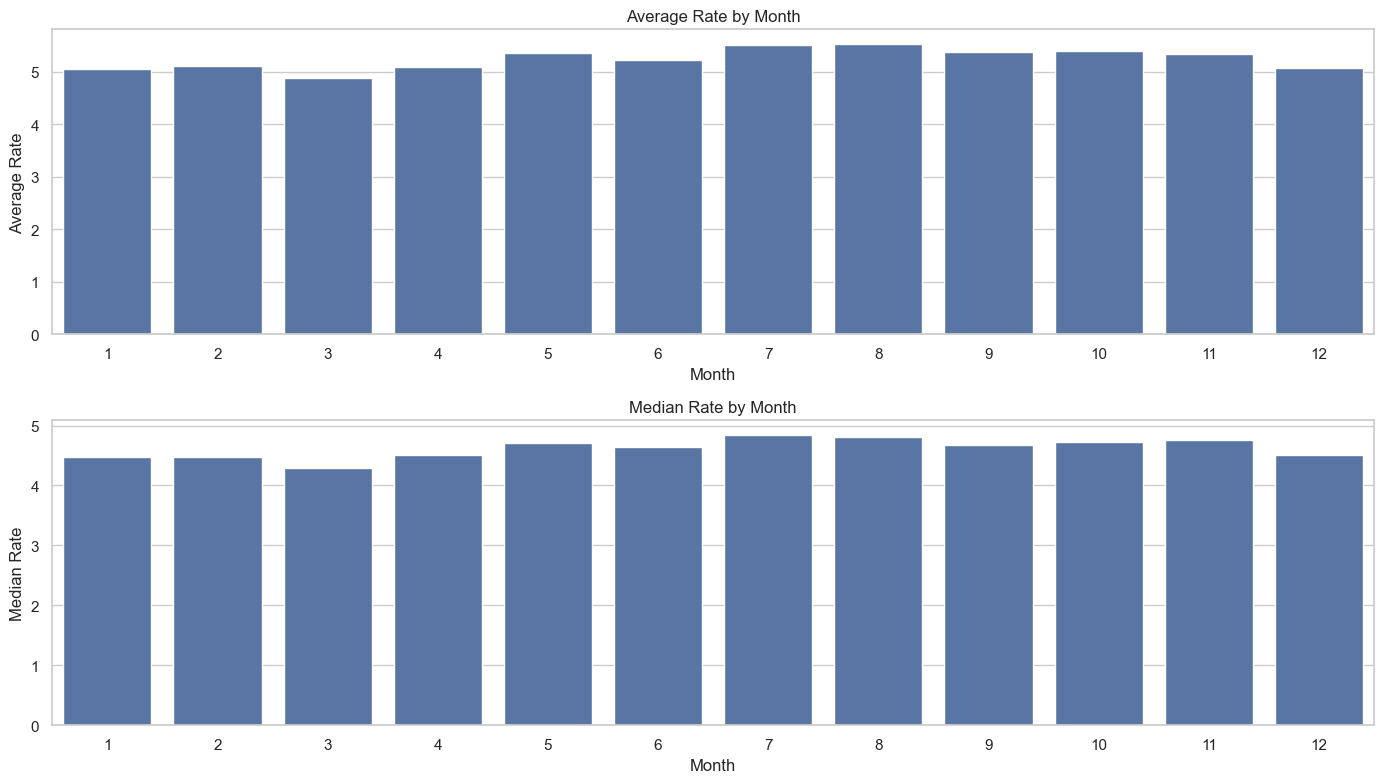

Mean rate:
month
1     5.055254
2     5.104352
3     4.885652
4     5.083433
5     5.366100
6     5.222437
7     5.512975
8     5.531950
9     5.374099
10    5.397531
11    5.335982
12    5.077195
Name: rate, dtype: float64

Median rate:
month
1     4.4756
2     4.4769
3     4.2841
4     4.5043
5     4.7143
6     4.6335
7     4.8432
8     4.8046
9     4.6734
10    4.7301
11    4.7566
12    4.5150
Name: rate, dtype: float64


In [55]:
barplot_rate_periodic_groupby("month")

## Hour

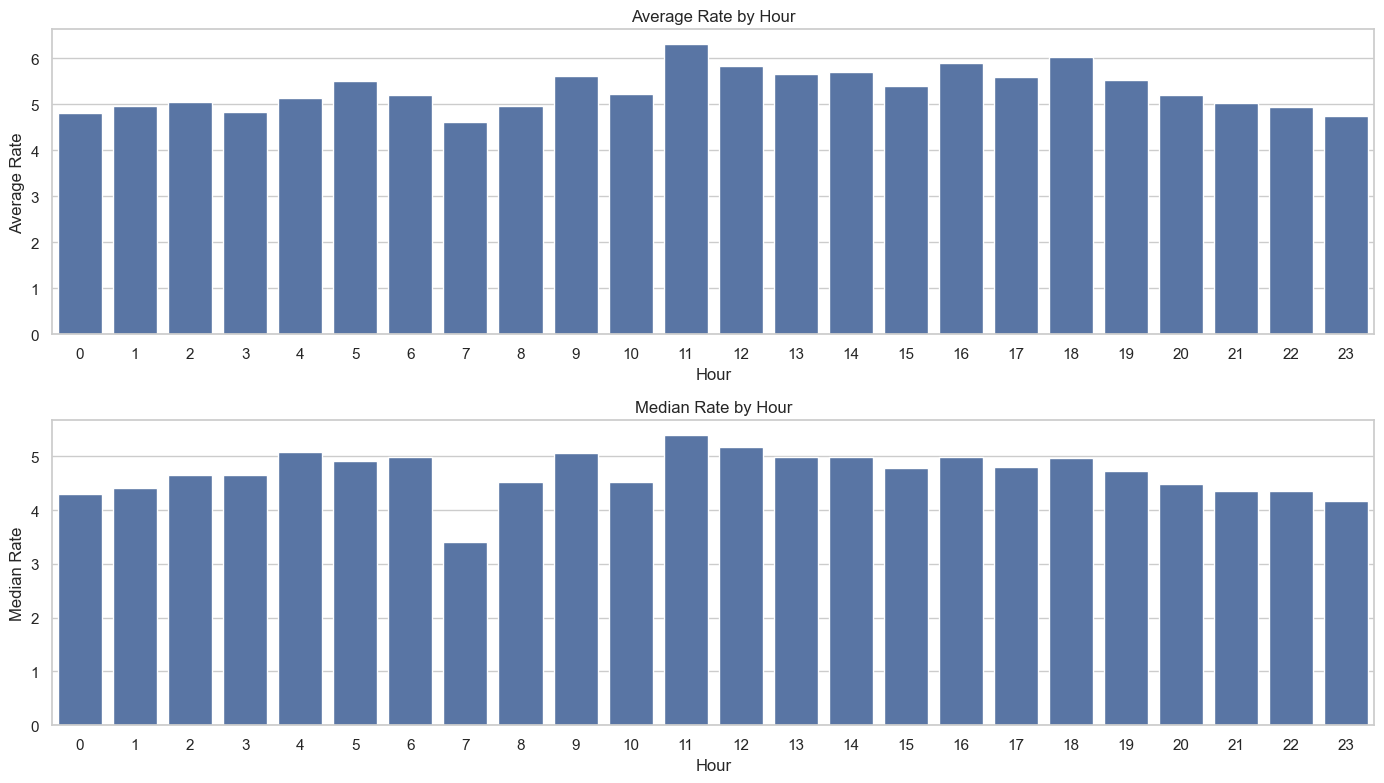

Mean rate:
hour
0     4.816492
1     4.966496
2     5.042754
3     4.829688
4     5.128912
5     5.499957
6     5.206612
7     4.607422
8     4.967196
9     5.613562
10    5.213618
11    6.310319
12    5.834962
13    5.646532
14    5.701575
15    5.390255
16    5.887332
17    5.583744
18    6.019240
19    5.528077
20    5.208985
21    5.025191
22    4.937976
23    4.735963
Name: rate, dtype: float64

Median rate:
hour
0     4.2929
1     4.4162
2     4.6572
3     4.6615
4     5.0748
5     4.9135
6     4.9820
7     3.4130
8     4.5292
9     5.0572
10    4.5256
11    5.3976
12    5.1686
13    4.9892
14    4.9892
15    4.7868
16    4.9892
17    4.8066
18    4.9728
19    4.7238
20    4.4903
21    4.3507
22    4.3507
23    4.1652
Name: rate, dtype: float64


In [56]:
barplot_rate_periodic_groupby("hour")

Различия между часами более выраженные, чем между месяцами.
- Минимальный rate (~4.60) в 07:00 (7 утра).
- Максимальный rate (~6.31) в 11:00 (11 утра).
- Второй пик (~6.02) в 18:00 (6 вечера).


Видны закономерности:
- Утром (07:00–08:00) цены ниже.
- В середине дня (11:00–12:00) наблюдается пик.
- Вечером (17:00–18:00) снова рост.

Добавляем hour в модель – он явно влияет на rate.

## Time of day

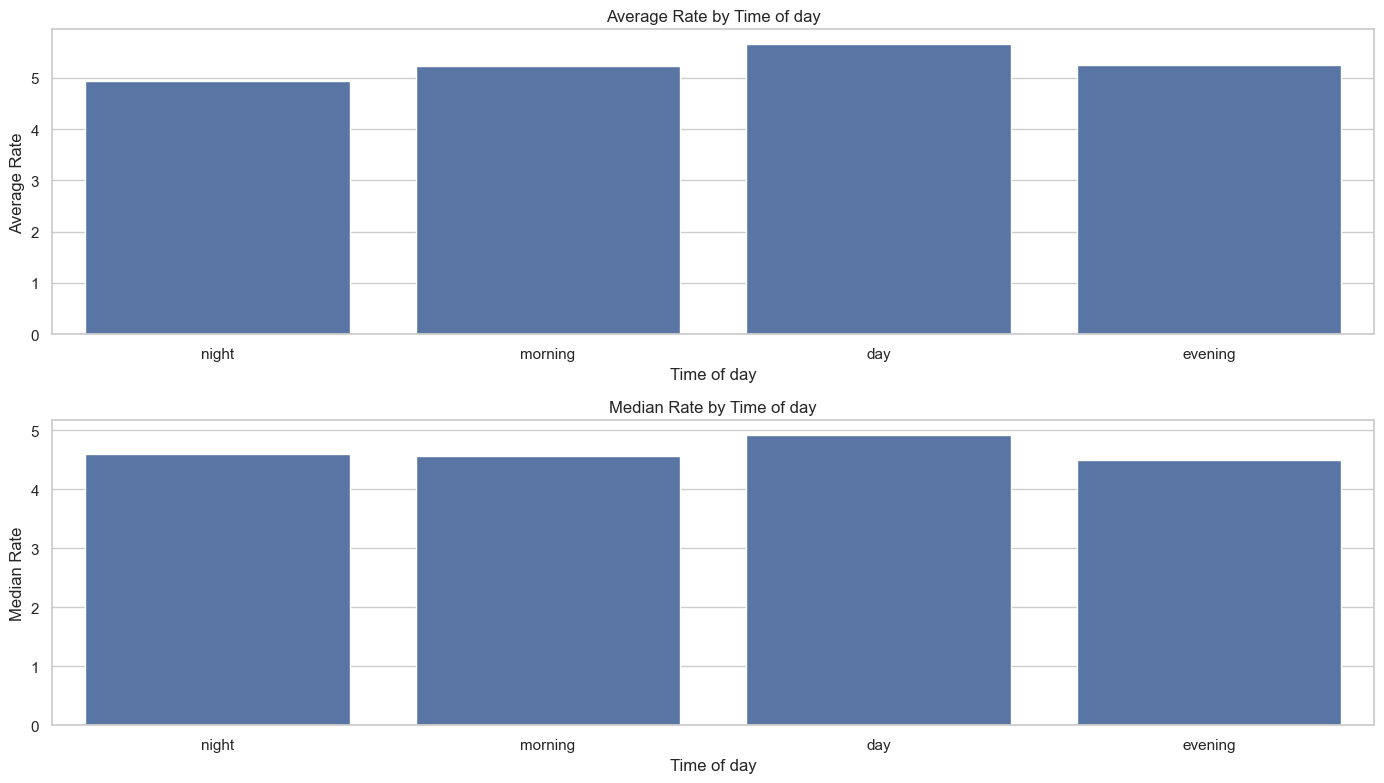

Mean rate:
time_of_day
night      4.941052
morning    5.237009
day        5.662210
evening    5.250842
Name: rate, dtype: float64

Median rate:
time_of_day
night      4.6044
morning    4.5601
day        4.9224
evening    4.4903
Name: rate, dtype: float64


In [57]:
barplot_rate_periodic_groupby("time_of_day")

## Day of week

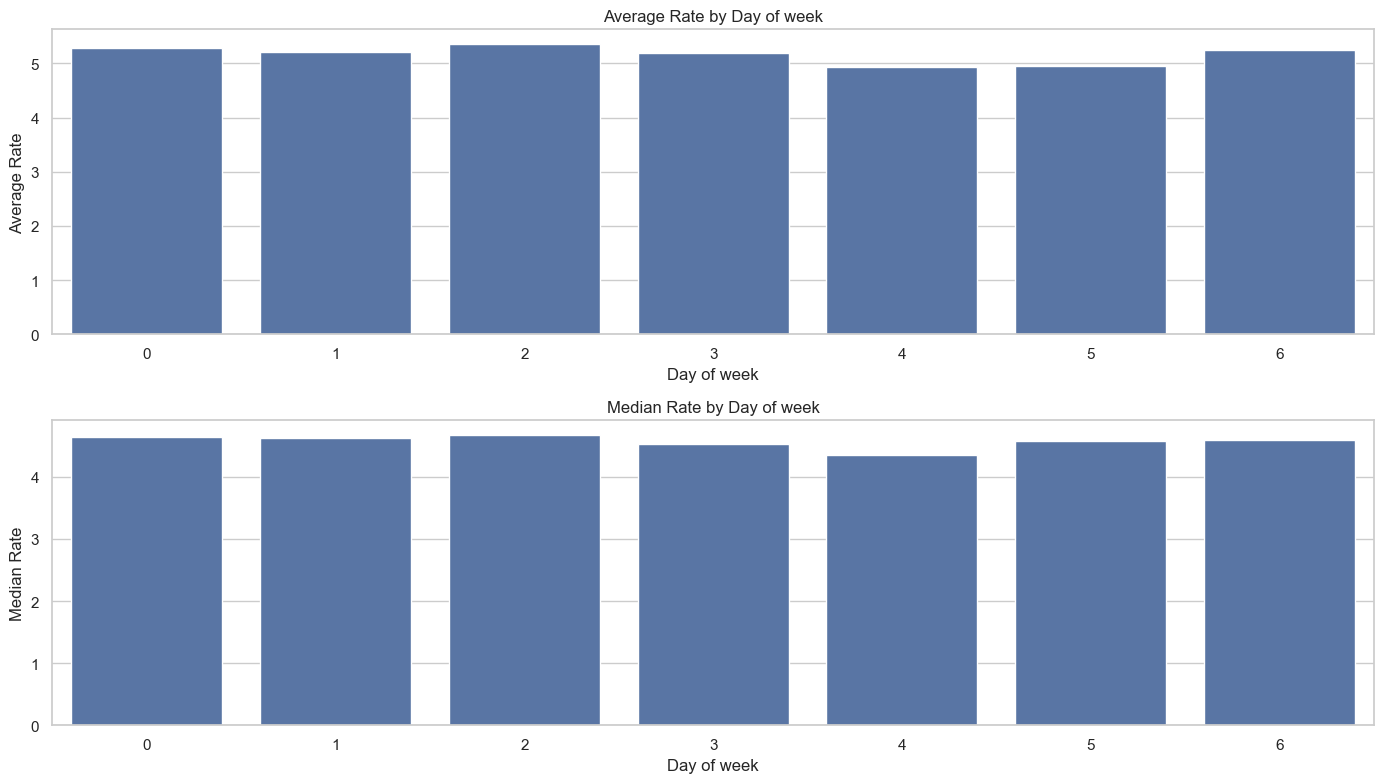

Mean rate:
day_of_week
0    5.277117
1    5.213474
2    5.359211
3    5.198457
4    4.933633
5    4.947984
6    5.253894
Name: rate, dtype: float64

Median rate:
day_of_week
0    4.63480
1    4.62025
2    4.67400
3    4.52040
4    4.35070
5    4.57410
6    4.59490
Name: rate, dtype: float64


In [58]:
barplot_rate_periodic_groupby("day_of_week")

Небольшие колебания в зависимости от дня недели
- Минимальный rate (~4.93) в четверг (4) и пятницу (5).
- Максимальный rate (~5.36) во вторник (2).
- Воскресенье (0) и суббота (6) также выше, чем будни.


Различия между днями недели слабее, чем между часами!
- Разница между минимумом (четверг) и максимумом (вторник) ~ 0.43.
- Это меньше, чем разница между разными часами суток (~1.5).


Добавляем day_of_week в модель, но влияние слабее, чем у hour.

# Seasonal decompose

<Figure size 1200x800 with 0 Axes>

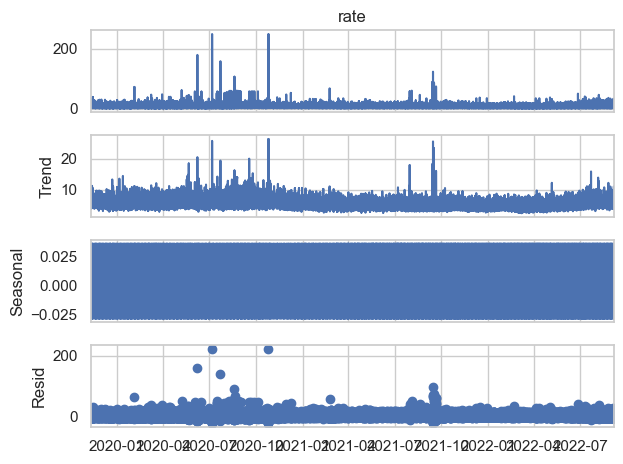

In [16]:
train_df = train_df.set_index("pickup_date")  # Делаем pickup_date индексом
result = seasonal_decompose(train_df["rate"], model="additive", period=12)

plt.figure(figsize=(12, 8))
result.plot()
plt.show()

разложение временного ряда на компоненты:
- rate (верхний график) – исходные данные.
- Trend (второй график) – долгосрочный тренд.
- Seasonal (третий график) – сезонность.
- Resid (четвертый график) – остатки (шум, выбросы).

Тренд (Trend):
- Виден некоторый рост и падение, но он неявный.
- Возможно, лучше использовать rolling mean (rolling_mean_rate_3m).

Сезонность (Seasonal):
- Фактически отсутствует!
- Значения почти нулевые, значит, месячная сезонность не выражена.

Остатки (Resid):
- Есть выбросы (rate > 200), их влияние нужно проверить.


- Месячная сезонность отсутствует → month не нужен.
- Тренд слабый, но он есть → rolling_mean_rate_3m может помочь.
- Выбросы (rate > 200) заметны в Resid → нужно проверить их влияние.

# Автокорреляция

Если есть сильная автокорреляция (значения ACF > 0.5), значит, rate зависит от предыдущих значений. В этом случае можно добавить лаги (lag_1, lag_7).

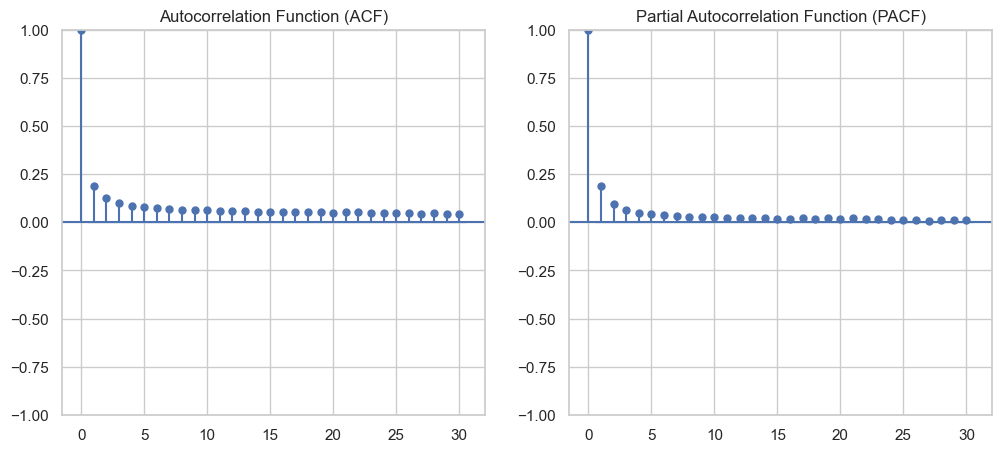

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(train_df["rate"], lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(train_df["rate"], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

- ACF (автокорреляция):
    - Показывает, как текущее значение rate связано с прошлыми значениями.
    - Если ACF высокий на lag_1, значит, вчерашний rate влияет на сегодняшний.
    - Значения постепенно убывают → есть слабая автокорреляция.
    - На лаге 1 (lag_1) корреляция около 0.25, но быстро спадает.
    - На lag_7 уже очень слабая корреляция.
- PACF (частичная автокорреляция):
    - Показывает чистую зависимость без влияния промежуточных шагов.
    - Если PACF высокий только на lag_1, значит, связь идёт только с предыдущим днем.
    - На lag_1 есть небольшой всплеск → возможно, зависимость на коротком интервале.
    - На более высоких лагах (lag_7 и дальше) зависимости почти нет.
- Есть краткосрочная автокорреляция (lag_1), но нет долгосрочной (lag_7).
- Автокорреляция слабая, но lag_1 можно попробовать добавить.

In [18]:
train_df["rate_lag_1"] = train_df["rate"].shift(1).fillna(0)

## ACF & PACF for residuals

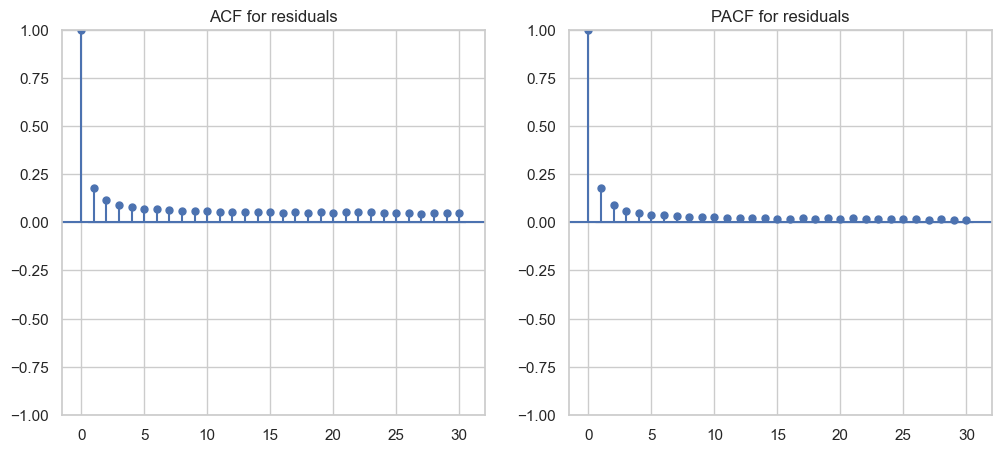

In [19]:
# Предсказываем rate на основе valid_miles и weight
X = train_df[["valid_miles", "weight"]]
y = train_df["rate"]

model = LinearRegression()
model.fit(X, y)
train_df["residuals"] = y - model.predict(X)  # Остаточная ошибка

# Пересчитываем ACF и PACF для ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(train_df["residuals"].dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF for residuals")

plot_pacf(train_df["residuals"].dropna(), lags=30, ax=axes[1])
axes[1].set_title("PACF for residuals")

plt.show()

## ACF for rate (origin_kma)

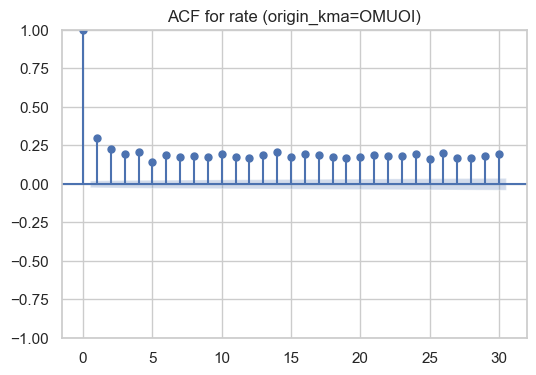

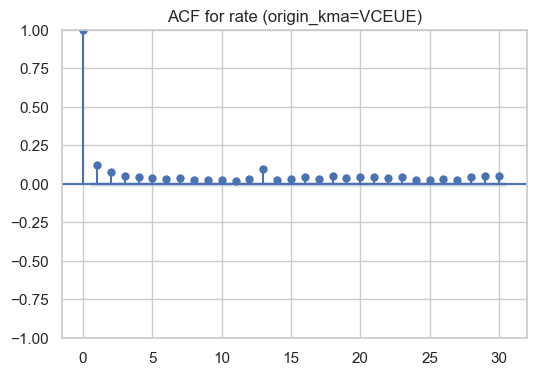

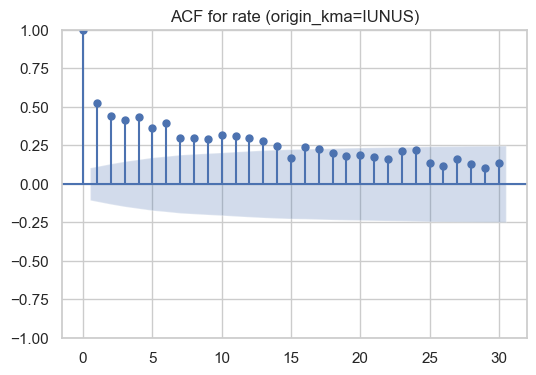

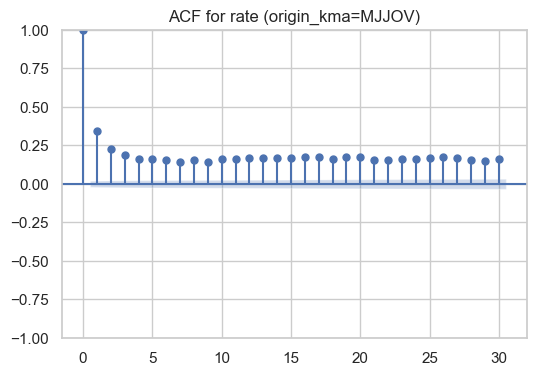

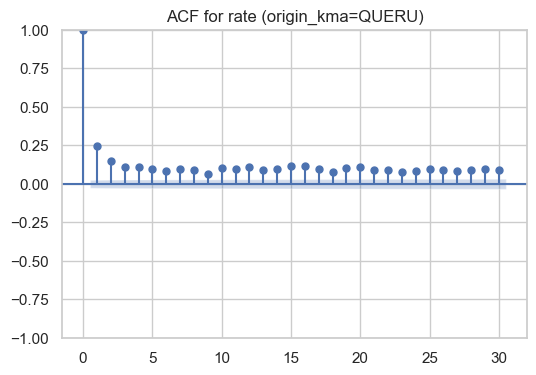

In [21]:
for kma in train_df["origin_kma"].unique()[:5]:  # Проверяем первые 5
    subset = train_df[train_df["origin_kma"] == kma]
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_acf(subset["rate"], lags=30, ax=ax)
    ax.set_title(f"ACF for rate (origin_kma={kma})")
    plt.show()


## ACF for rate (transport_type)

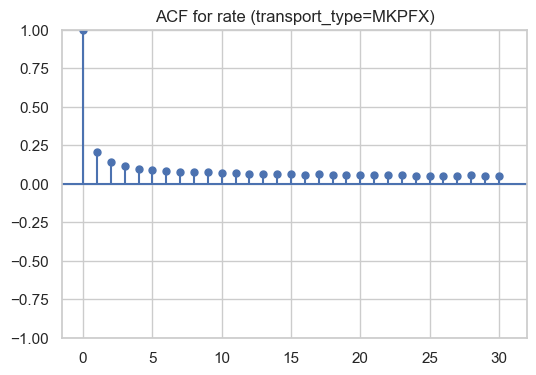

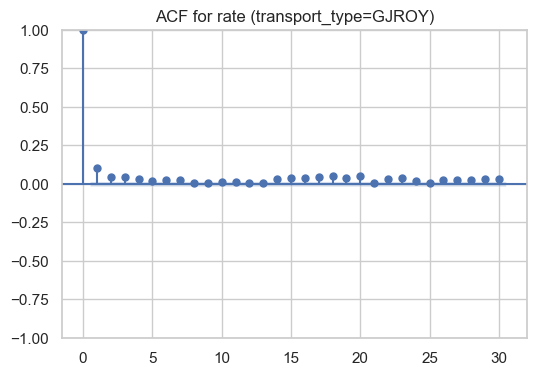

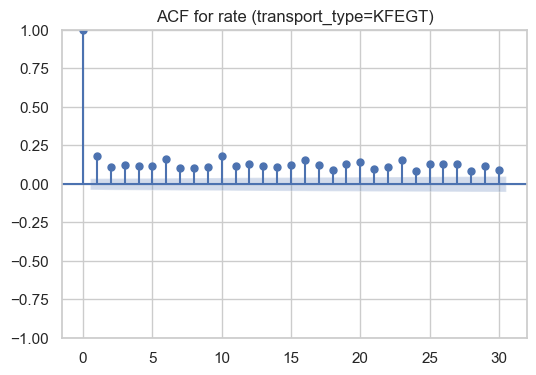

In [23]:
for transport in train_df["transport_type"].unique():
    subset = train_df[train_df["transport_type"] == transport]
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_acf(subset["rate"], lags=30, ax=ax)
    ax.set_title(f"ACF for rate (transport_type={transport})")
    plt.show()


## ACF for rate (time_of_day)

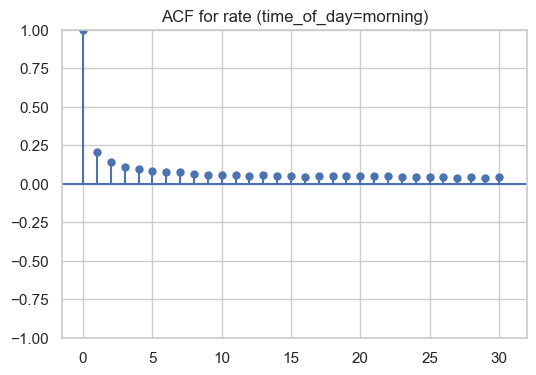

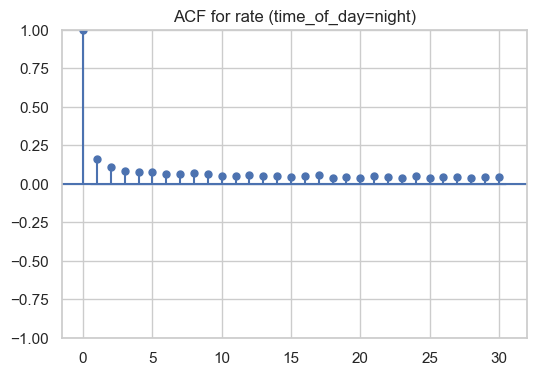

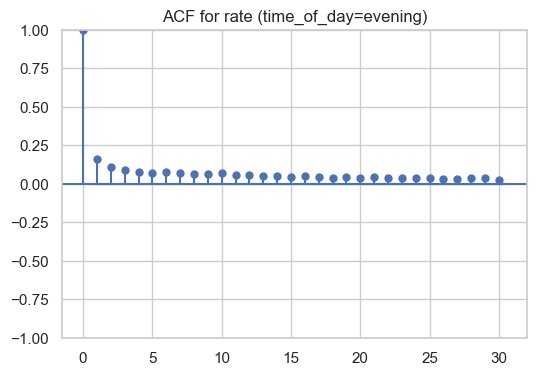

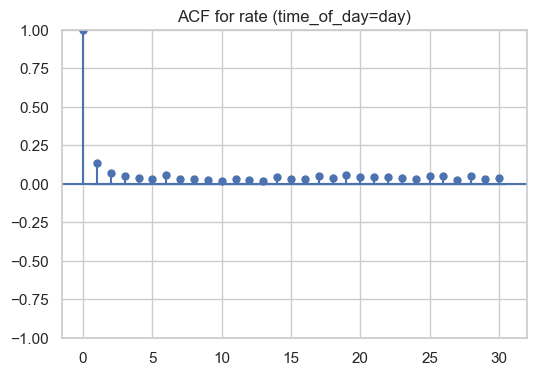

In [26]:
for time in train_df["time_of_day"].unique():
    subset = train_df[train_df["time_of_day"] == time]
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_acf(subset["rate"], lags=30, ax=ax)
    ax.set_title(f"ACF for rate (time_of_day={time})")
    plt.show()

# Стационарность ряда (тест Дики-Фуллера)

In [27]:
adf_test = adfuller(train_df["rate"])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Statistic: -38.25653682056136
p-value: 0.0


rate уже стационарен → дифференцировать не нужно.

Это означает, что rate не имеет тренда, и стандартные методы машинного обучения могут работать с ним напрямую, без дополнительной обработки (например, rate.diff())